<h1> Coursera - IBM Datascience Capstone - Week 3 </h1>

In [1]:
#  make sure libs are installed:
!pip install pandas
!pip install requests
!pip install bs4

#  imports required:
import pandas as pd
import requests
from bs4 import BeautifulSoup

<h2> Get Post Code Data </h2>

In [2]:
#  get table from url:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(url).text

#  Convert to Beautiful soup object:
soup = BeautifulSoup(html_data, "html5lib")
tables = soup.find_all('table')

#  after looking at results, id 0 is the correct table.
table_id = 0

#  need to loop through each row and column to pull apart post code and location:
post_codes = pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
table_rows = tables[table_id].find_all('td')

for row in table_rows:
    post_code = (row.p.b.text)
    cell_content =row.span.text.split("(")
    if len(cell_content) > 1:
        borough = cell_content[0]
        neighborhood = cell_content[1].replace(")","").replace("/", ", ")
        post_codes = post_codes.append({"PostalCode":post_code, "Borough": borough, "Neighborhood":neighborhood}, ignore_index = True)

In [3]:
post_codes.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


<h2> Get Location Data </h2>

In [4]:
geospatial_data = pd.read_csv('https://cocl.us/Geospatial_data')
geospatial_data.columns = ['PostalCode', 'Latitude', 'Longitude']
geospatial_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [160]:
post_codes_locations = pd.merge(post_codes, geospatial_data, on="PostalCode")
post_codes_locations.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [162]:
post_codes_locations.shape

(103, 5)

<h2> Explore Clustering </h2>

The below cell will stipulate secret codes to be used in the url generation (hidden)

In [6]:
# @hidden_cell



In [7]:
toronto_boroughs = post_codes_locations[post_codes_locations['Borough'].str.contains("Toronto")].reset_index()
toronto_boroughs.head()

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,19,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


<h3> Import ability to call FourSquare API: </h3>

In [8]:
import requests

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
toronto_borough_venues = getNearbyVenues(names = toronto_boroughs['Neighborhood'],
                                         latitudes = toronto_boroughs['Latitude'],
                                         longitudes = toronto_boroughs['Longitude']
                                        )


In [65]:
toronto_borough_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park , Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [91]:
toronto_one_hot = pd.get_dummies(toronto_borough_venues[['Venue Category']], prefix="", prefix_sep="")

#  one hot has removed neighborhood names:
toronto_one_hot["Neighborhood"] = toronto_borough_venues['Neighborhood']
#  rearrange to make borough first:
fixed_order = [toronto_one_hot.columns[-1]] + list(toronto_one_hot.columns[:-1])
toronto_one_hot = toronto_one_hot[fixed_order]

In [92]:
#  normalise results to be an average value for borough:
toronto_grouped = toronto_one_hot.groupby("Neighborhood").mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"CN Tower , King and Spadina , Railway Lands ...",0.000000,0.066667,0.066667,0.133333,0.2,0.133333,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Central Bay Street,0.033333,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000
4,Christie,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Commerce Court , Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.066667,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333
7,Davisville,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Davisville North,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Dufferin , Dovercourt Village",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [93]:
#  to match past assignment we will use k-means to cluster boroughs:
# import k-means from clustering stage
import numpy as np
#!pip install scikit-learn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.utils
sklearn.utils.check_random_state(1000)

RandomState(MT19937) at 0x7F9D17A6D8D0

In [133]:
#  pre-process data for kMeans:
toronto_clustered = toronto_grouped.drop("Neighborhood",1)
toronto_clustered = np.nan_to_num(toronto_clustered)
toronto_clustered = StandardScaler().fit_transform(toronto_clustered)

#  Compute DBSCAN:
kcluster = 6
kmeans = KMeans(n_clusters=kcluster, random_state = 0).fit(toronto_clustered)

<h3> Get Top Venues </h3>

In [134]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Seafood Restaurant,Beer Bar,Coffee Shop,Cocktail Bar,Farmers Market,Fish Market,Basketball Stadium,Bistro,French Restaurant,Fountain
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Furniture / Home Store,Convenience Store,Stadium,Bar,Nightclub,Bakery
2,"CN Tower , King and Spadina , Railway Lands ...",Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Coffee Shop,Rental Car Location,Sculpture Garden,Plane,Airport
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Yoga Studio,Comic Shop,Bubble Tea Shop,Sandwich Place,Ramen Restaurant,Portuguese Restaurant,Park
4,Christie,Grocery Store,Café,Park,Restaurant,Baby Store,Candy Store,Nightclub,Italian Restaurant,Athletics & Sports,Coffee Shop


In [135]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [136]:
toronto_merged = toronto_boroughs
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Restaurant,Chocolate Shop,Pub,Performing Arts Venue,Yoga Studio
1,9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.0,Café,Clothing Store,Theater,Ramen Restaurant,Shopping Mall,Burrito Place,Burger Joint,Mexican Restaurant,Sandwich Place,Fast Food Restaurant
2,15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4.0,Café,Gastropub,Coffee Shop,Restaurant,Farmers Market,Food Truck,BBQ Joint,Creperie,Park,Cocktail Bar
3,19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.0,Health Food Store,Trail,Pub,Yoga Studio,Music Venue,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
4,20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,4.0,Seafood Restaurant,Beer Bar,Coffee Shop,Cocktail Bar,Farmers Market,Fish Market,Basketball Stadium,Bistro,French Restaurant,Fountain


<h3> Folium Map </h3>

In [107]:
!pip install folium
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors

In [139]:
toronto_merged = toronto_merged.dropna()

In [157]:
# create map
map_clusters = folium.Map(location=[toronto_merged['Latitude'][0], toronto_merged['Longitude'][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters

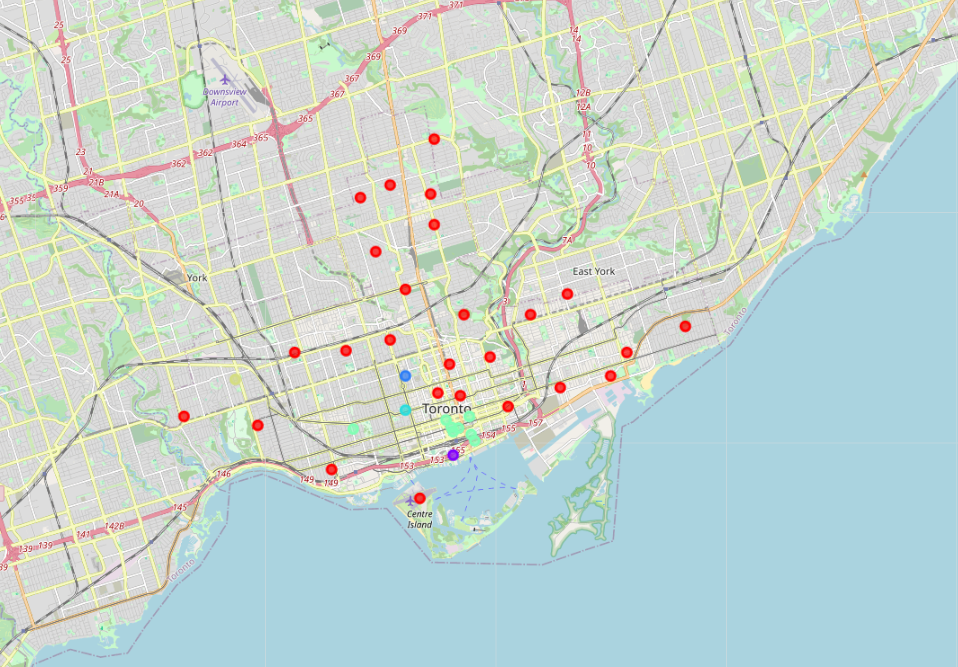

In [158]:
#  CLuster 0 = Parks and Cafes
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,-79.360636,0.0,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Restaurant,Chocolate Shop,Pub,Performing Arts Venue,Yoga Studio
1,M5B,-79.378937,0.0,Café,Clothing Store,Theater,Ramen Restaurant,Shopping Mall,Burrito Place,Burger Joint,Mexican Restaurant,Sandwich Place,Fast Food Restaurant
3,M4E,-79.293031,0.0,Health Food Store,Trail,Pub,Yoga Studio,Music Venue,Martial Arts School,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant
5,M5G,-79.387383,0.0,Coffee Shop,Italian Restaurant,Café,Yoga Studio,Comic Shop,Bubble Tea Shop,Sandwich Place,Ramen Restaurant,Portuguese Restaurant,Park
6,M6G,-79.422564,0.0,Grocery Store,Café,Park,Restaurant,Baby Store,Candy Store,Nightclub,Italian Restaurant,Athletics & Sports,Coffee Shop
8,M6H,-79.442259,0.0,Pharmacy,Bakery,Grocery Store,Café,Brewery,Pool,Park,Middle Eastern Restaurant,Supermarket,Bar
9,M4J,-79.338106,0.0,Pizza Place,Intersection,Metro Station,Park,Convenience Store,Martial Arts School,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant
12,M4K,-79.352188,0.0,Greek Restaurant,Ice Cream Shop,Italian Restaurant,Yoga Studio,Furniture / Home Store,Fruit & Vegetable Store,Spa,Cosmetics Shop,Bookstore,Brewery
14,M6K,-79.428191,0.0,Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Furniture / Home Store,Convenience Store,Stadium,Bar,Nightclub,Bakery
15,M4L,-79.315572,0.0,Park,Fast Food Restaurant,Board Shop,Pub,Brewery,Sandwich Place,Liquor Store,Pet Store,Fish & Chips Shop,Food & Drink Shop


In [159]:
#  CLuster 4 = Food Places
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5C,-79.375418,4.0,Café,Gastropub,Coffee Shop,Restaurant,Farmers Market,Food Truck,BBQ Joint,Creperie,Park,Cocktail Bar
4,M5E,-79.373306,4.0,Seafood Restaurant,Beer Bar,Coffee Shop,Cocktail Bar,Farmers Market,Fish Market,Basketball Stadium,Bistro,French Restaurant,Fountain
7,M5H,-79.384568,4.0,Coffee Shop,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Steakhouse,Speakeasy,Smoke Shop,Fast Food Restaurant,Restaurant
11,M6J,-79.419750,4.0,Bar,Asian Restaurant,Vietnamese Restaurant,Men's Store,Brewery,Cocktail Bar,Coffee Shop,Cuban Restaurant,French Restaurant,Greek Restaurant
13,M5K,-79.381576,4.0,Café,Coffee Shop,Restaurant,Bakery,Japanese Restaurant,Wine Bar,Gym,Hotel,Museum,Deli / Bodega
16,M5L,-79.379817,4.0,Café,Hotel,Coffee Shop,Gastropub,American Restaurant,Restaurant,Wine Bar,Seafood Restaurant,Sandwich Place,Pub
34,M5W,-79.374846,4.0,Seafood Restaurant,Café,Cocktail Bar,Farmers Market,Beer Bar,Comfort Food Restaurant,Creperie,Restaurant,Coffee Shop,Concert Hall
36,M5X,-79.382280,4.0,Café,Coffee Shop,Restaurant,Hotel,Seafood Restaurant,Wine Bar,Bakery,Gym,Gluten-free Restaurant,Gastropub
